In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('ggplot')

In [55]:
pip install plotnine

Note: you may need to restart the kernel to use updated packages.


In [56]:
# pip install --upgrade patsy

# DATA ACQUISITION

In [4]:
df = pd.read_csv('Proveindustriales_Data_Cleaned_Kprototipe_csv.csv')

In [5]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'SUBCATEGORÍA',
       'PROVEEDOR', 'PRESUPUESTO', 'COMPAÑÍA_COMPRADORA', 'ESTADO',
       'PRODUCTO_O_SERVICIO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'PRECIO_UNITARIO_+_IVA', 'IVA', 'TOTAL_SIN_IVA',
       'TOTAL_+_IVA', 'FECHA_ÚLTIMO_MOVIMIENTO', 'DURACIÓN_ENTREGA',
       'DURACIÓN_APROBACIÓN'],
      dtype='object')

In [6]:
df.sample(2)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,SUBCATEGORÍA,PROVEEDOR,PRESUPUESTO,COMPAÑÍA_COMPRADORA,ESTADO,PRODUCTO_O_SERVICIO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,PRECIO_UNITARIO_+_IVA,IVA,TOTAL_SIN_IVA,TOTAL_+_IVA,FECHA_ÚLTIMO_MOVIMIENTO,DURACIÓN_ENTREGA,DURACIÓN_APROBACIÓN
13921,36200,667,Vigilancia y seguridad industrial,Seguridad y protección personal,Proveedor 301,Presupuesto 736,Portal comprador 24,Recibido,84 Zueco dotación antideslizante,12.000,12.000,72222.000,85944.000,13722,866662.000,1031328.000,2020-01-24,0.000,16.000
18097,1069,86,Moda y accesorios,Calzado,Proveedor 229,Presupuesto 59,Portal comprador 8,Recibido,Botas,4.000,4.000,29412.000,35000.000,5588,117647.000,140000.000,2019-10-18,3.242,0.000


## IRRELEVANT COLUMNS

In [7]:
cols_to_drop = ['FECHA_ÚLTIMO_MOVIMIENTO','DURACIÓN_ENTREGA', 'DURACIÓN_APROBACIÓN', 'PRECIO_UNITARIO_+_IVA', 'TOTAL_+_IVA', 'PRESUPUESTO', 'SUBCATEGORÍA', 'PRODUCTO_O_SERVICIO']

In [8]:
df.drop(cols_to_drop, inplace=True, axis=1)

## DF ORIGINAL

In [9]:
df.head(3)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,PROVEEDOR,COMPAÑÍA_COMPRADORA,ESTADO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,49561,2582,Eléctricos y Electrónicos,Proveedor 1,Portal comprador 1,Orden en Proceso,2.000,0.000,23364.000,4439,46728.000
1,49560,2581,Mercadeo y publicidad,Proveedor 2,Portal comprador 1,Recibido,1.000,1.000,1476972.000,280625,1476972.000
2,49559,2580,Alimentos y Bebidas,Proveedor 3,Portal comprador 1,Orden en Proceso,10.000,0.000,15500.000,0,155000.000


In [10]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'PROVEEDOR',
       'COMPAÑÍA_COMPRADORA', 'ESTADO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'IVA', 'TOTAL_SIN_IVA'],
      dtype='object')

## CHECK INSA()

In [11]:
df.isna().sum()

NÚMERO_PEDIDO          0
ORDEN_NÚMERO           0
CATEGORÍA              0
PROVEEDOR              0
COMPAÑÍA_COMPRADORA    0
ESTADO                 0
CANTIDAD_PEDIDA        0
CANTIDAD_RECIBIDA      0
PRECIO_UNITARIO        0
IVA                    0
TOTAL_SIN_IVA          0
dtype: int64

In [12]:
df.select_dtypes('object').nunique()

CATEGORÍA               36
PROVEEDOR              405
COMPAÑÍA_COMPRADORA     33
ESTADO                   9
dtype: int64

## DISTRIBUTION OF ALL "COMPAÑIAS COMPRADORAS"

In [13]:
df_COMPANHIA_COMPRADORA = pd.DataFrame(df['COMPAÑÍA_COMPRADORA'].value_counts()).reset_index()

In [14]:
df_COMPANHIA_COMPRADORA['Percentage'] = df_COMPANHIA_COMPRADORA['COMPAÑÍA_COMPRADORA'] / df['COMPAÑÍA_COMPRADORA'].value_counts().sum()

In [15]:
df_COMPANHIA_COMPRADORA.rename(columns = {'index':'COMPAÑÍA_COMPRADORA', 'COMPAÑÍA_COMPRADORA':'Total'}, inplace = True)


## CREATE THE DATAFRAME OF "COMPANHIA_COMPRADORA"

In [16]:
df_COMPANHIA_COMPRADORA.head(2)

,COMPAÑÍA_COMPRADORA,Total,Percentage
0,Portal comprador 1,6563,0.293
1,Portal comprador 24,5439,0.243


### Sort values by TOTAL

In [17]:
df_COMPANHIA_COMPRADORA = df_COMPANHIA_COMPRADORA.sort_values('Total', ascending = True).reset_index(drop = True)

In [18]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'PROVEEDOR',
       'COMPAÑÍA_COMPRADORA', 'ESTADO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'IVA', 'TOTAL_SIN_IVA'],
      dtype='object')

## GROUP BY COMPAÑÍA_COMPRADORA

In [19]:
# The dataframe
df_COMPANHIA_COMPRADORA = df.groupby('COMPAÑÍA_COMPRADORA').agg({
    'COMPAÑÍA_COMPRADORA': 'count',
    'CANTIDAD_PEDIDA': 'sum',
    'CANTIDAD_RECIBIDA': 'sum',
    'PRECIO_UNITARIO': 'mean',
    'IVA': 'sum',
    'TOTAL_SIN_IVA': 'sum'
    }
).rename(columns = {'COMPAÑÍA_COMPRADORA': 'Total'}).reset_index().sort_values('Total', ascending = True)

In [20]:
df_COMPANHIA_COMPRADORA.sort_values(by='Total', ascending=False).head(2)

,COMPAÑÍA_COMPRADORA,Total,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,Portal comprador 1,6563,432971.200,414527.300,165470.905,166869025,2742179393.000
16,Portal comprador 24,5439,231092.000,231092.000,39930.220,41264145,4293598558.000


## CROSS TAB "CATEGORY"

In [21]:
order_COMPANHIA = df_COMPANHIA_COMPRADORA['COMPAÑÍA_COMPRADORA'].to_list()

In [22]:
order_COMPANHIA.append('All')

In [23]:
(pd.crosstab(df['COMPAÑÍA_COMPRADORA'], df['CATEGORÍA'], margins = True).reindex(order_COMPANHIA, axis = 0).reset_index()).sort_values(by='All', ascending='True').head(7)

CATEGORÍA,COMPAÑÍA_COMPRADORA,Agroindustrial,Alimentos y Bebidas,Almacenamiento y empaques,"Aseo, Cafetería y Oficina",Compras Sostenibles,Construcción y Mantenimiento,Cuidado personal y Belleza,Deporte y recreación,Dotación y elementos de protección personal,...,Salud y Medicina,Servicios Profesionales,Servicios Públicos,Tecnología e información,Textiles,Vehículos y repuestos,"Viajes, Eventos y Entretenimiento",Vigilancia y seguridad,Vigilancia y seguridad industrial,All
0,Portal comprador 9,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Portal comprador 33,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Portal comprador 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Portal comprador 25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,Portal comprador 22,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Portal comprador 19,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,Portal comprador 17,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [24]:
df_CATEGORIA = pd.crosstab(df['COMPAÑÍA_COMPRADORA'], df['CATEGORÍA'], margins = True).reindex(order_COMPANHIA, axis = 0).reset_index()

In [25]:
# Remove index name
df_CATEGORIA.columns.name = None
df_CATEGORIA.head(3)

,COMPAÑÍA_COMPRADORA,Agroindustrial,Alimentos y Bebidas,Almacenamiento y empaques,"Aseo, Cafetería y Oficina",Compras Sostenibles,Construcción y Mantenimiento,Cuidado personal y Belleza,Deporte y recreación,Dotación y elementos de protección personal,...,Salud y Medicina,Servicios Profesionales,Servicios Públicos,Tecnología e información,Textiles,Vehículos y repuestos,"Viajes, Eventos y Entretenimiento",Vigilancia y seguridad,Vigilancia y seguridad industrial,All
0,Portal comprador 9,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Portal comprador 33,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Portal comprador 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## GET POSITION OF CATEGORICAL COLS

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22392 entries, 0 to 22391
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NÚMERO_PEDIDO        22392 non-null  int64  
 1   ORDEN_NÚMERO         22392 non-null  int64  
 2   CATEGORÍA            22392 non-null  object 
 3   PROVEEDOR            22392 non-null  object 
 4   COMPAÑÍA_COMPRADORA  22392 non-null  object 
 5   ESTADO               22392 non-null  object 
 6   CANTIDAD_PEDIDA      22392 non-null  float64
 7   CANTIDAD_RECIBIDA    22392 non-null  float64
 8   PRECIO_UNITARIO      22392 non-null  float64
 9   IVA                  22392 non-null  int64  
 10  TOTAL_SIN_IVA        22392 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.9+ MB


In [27]:
[df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

[2, 3, 4, 5]

In [28]:
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]

In [29]:
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['CATEGORÍA', 'PROVEEDOR', 'COMPAÑÍA_COMPRADORA', 'ESTADO']
Categorical columns position  : [2, 3, 4, 5]


## CONVERT DF TO MATRIX WITH NUMPY

In [30]:
dfMatrix = df.to_numpy()
dfMatrix

array([[49561, 2582, 'Eléctricos y Electrónicos', ..., 23364.0, 4439,
        46728.0],
       [49560, 2581, 'Mercadeo y publicidad', ..., 1476972.0, 280625,
        1476972.0],
       [49559, 2580, 'Alimentos y Bebidas', ..., 15500.0, 0, 155000.0],
       ...,
       [2, 2, 'Moda y accesorios', ..., 29412.0, 5588, 88235.0],
       [1, 1, 'Moda y accesorios', ..., 29412.0, 5588, 117647.0],
       [1, 1, 'Aseo, Cafetería y Oficina', ..., 33613.0, 6387, 168067.0]],
      dtype=object)

## OPTIMAL K USING ELBOW METHOD

In [84]:
# cost = []
# for cluster in range(2, 10):
#     try:
#         kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
#         kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
#         cost.append(kprototype.cost_)
#         print('Cluster initiation: {}'.format(cluster))
#     except:
#         break

In [85]:
# # Converting the results into a dataframe and plotting them
# df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
# # Data viz
# plotnine.options.figure_size = (8, 4.8)
# (
#     ggplot(data = df_cost)+
#     geom_line(aes(x = 'Cluster',
#                   y = 'Cost'))+
#     geom_point(aes(x = 'Cluster',
#                    y = 'Cost'))+
#     geom_label(aes(x = 'Cluster',
#                    y = 'Cost',
#                    label = 'Cluster'),
#                size = 10,
#                nudge_y = 1000) +
#     labs(title = 'Optimal number of cluster with Elbow Method')+
#     xlab('Number of Clusters k')+
#     ylab('Cost')+
#     theme_minimal()
# )

## FTI MODEL WITH K CLUSTER

In [31]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

### CENTROIDS

In [32]:
# Cluster centorid
kprototype.cluster_centroids_

array([['35118.290762083445', '708.1657732511391', '196.63882024479585',
        '49.44693379790941', '70171.90896095773', '11119.092021799339',
        '438847.03658536583', 'Alimentos y Bebidas', 'Proveedor 301',
        'Portal comprador 1', 'Recibido'],
       ['44690.666666666664', '1017.3333333333334', '348.5',
        '333.6666666666618', '14637658.5', '1431559.8333333333',
        '144911652.33333334', 'Construcción y Mantenimiento',
        'Proveedor 20', 'Portal comprador 1', 'Orden en Proceso']],
      dtype='<U32')

N_ITER

In [33]:

# Check the iteration of the clusters created
kprototype.n_iter_

8

### COST_

In [34]:

# Check the cost of the clusters created
kprototype.cost_

1.0673966121269589e+17

## ADD THE CLUSTER TO THE DF

In [35]:
df['Cluster Labels'] = kprototype.labels_
df['Segment'] = df['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})

In [36]:
len(kprototype.labels_)

22392

In [40]:
df.head(4)

,NÚMERO_PEDIDO,ORDEN_NÚMERO,CATEGORÍA,PROVEEDOR,COMPAÑÍA_COMPRADORA,ESTADO,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA,Cluster Labels,Segment
0,49561,2582,Eléctricos y Electrónicos,Proveedor 1,Portal comprador 1,Orden en Proceso,2.000,0.000,23364.000,4439,46728.000,0,First
1,49560,2581,Mercadeo y publicidad,Proveedor 2,Portal comprador 1,Recibido,1.000,1.000,1476972.000,280625,1476972.000,0,First
2,49559,2580,Alimentos y Bebidas,Proveedor 3,Portal comprador 1,Orden en Proceso,10.000,0.000,15500.000,0,155000.000,0,First
3,49558,1892,Alimentos y Bebidas,Proveedor 4,Portal comprador 2,Orden en Proceso,50.000,0.000,22000.000,0,1100000.000,0,First


In [41]:
#df.to_csv("Kprototype_clusters_2:Companhia.csv")

## ORDER CLUSTER

In [92]:
# Order the cluster
df['Segment'] = df['Segment'].astype('category')
df['Segment'] = df['Segment'].cat.reorder_categories(['First','Second'])

In [97]:
df.columns

Index(['NÚMERO_PEDIDO', 'ORDEN_NÚMERO', 'CATEGORÍA', 'PROVEEDOR',
       'COMPAÑÍA_COMPRADORA', 'ESTADO', 'CANTIDAD_PEDIDA', 'CANTIDAD_RECIBIDA',
       'PRECIO_UNITARIO', 'IVA', 'TOTAL_SIN_IVA', 'Total', 'Segment'],
      dtype='object')

## CLUSTER INTERPRETATION

In [98]:
# Cluster interpretation
df.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df.groupby('Segment').agg(
    {
        'Total':'count',
        'COMPAÑÍA_COMPRADORA': lambda x: x.value_counts().index[0],
        'CATEGORÍA':lambda x: x.value_counts().index[0],
        'ESTADO':lambda x: x.value_counts().index[0],
        'PROVEEDOR':lambda x: x.value_counts().index[0],
        'CANTIDAD_PEDIDA': 'sum',
        'CANTIDAD_RECIBIDA': 'sum',
        'PRECIO_UNITARIO': 'mean',
        'IVA': 'sum',
        'TOTAL_SIN_IVA': 'sum'

    }
).reset_index()

,Segment,Total,COMPAÑÍA_COMPRADORA,CATEGORÍA,ESTADO,PROVEEDOR,CANTIDAD_PEDIDA,CANTIDAD_RECIBIDA,PRECIO_UNITARIO,IVA,TOTAL_SIN_IVA
0,First,22386,Portal comprador 1,Alimentos y Bebidas,Recibido,Proveedor 301,4401956.630,1106919.060,70171.909,248911994,9824029761.000
1,Second,6,Portal comprador 1,Construcción y Mantenimiento,Orden en Proceso,Proveedor 20,2091.000,2002.000,14637658.500,8589359,869469914.000


In [102]:
df.groupby('Segment')['Segment'].count()

Segment
First     22386
Second        6
Name: Segment, dtype: int64

# FAMD

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (1.29% inertia)', ylabel='Component 1 (0.96% inertia)'>

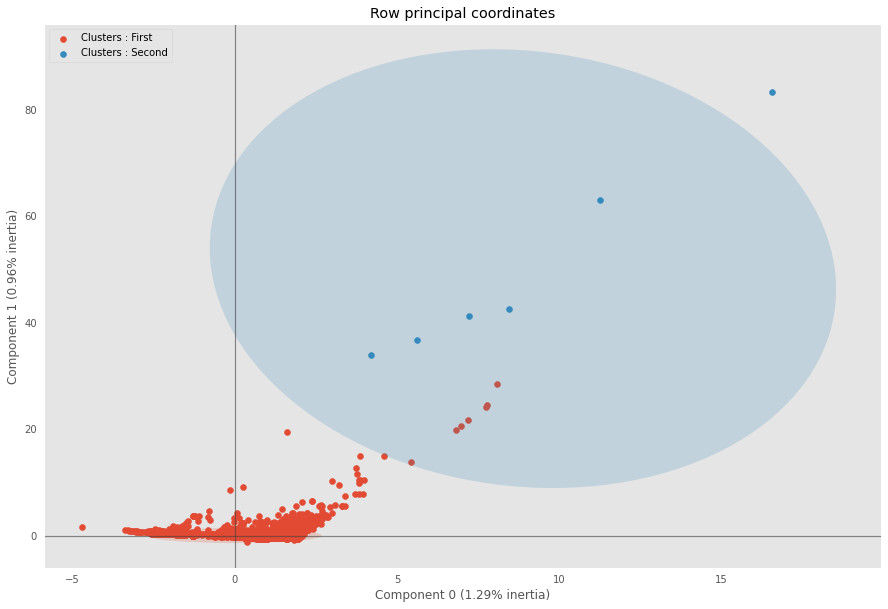

In [39]:
from prince import FAMD

X=pd.read_csv("Kprototype_clusters_2:Companhia.csv")

famd = FAMD(n_components =2, n_iter = 3, random_state = 101)

famd.fit(X)
famd.transform(X)
famd.plot_row_coordinates(X,figsize=(15, 10),color_labels=['Clusters : {}'.format(t) for t in X['Segment']] )

#X.get_figure().savefig('images/famd_row_coordinates.svg')
